<a href="https://colab.research.google.com/github/Max-jones/suffix-trees/blob/master/TFSAX_wPST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema Experto: Detección de tendencias anómalas

Instalaciones necesarias


In [1]:
! pip install saxpy
import saxpy

! pip install suffix_trees

     |████████████████████████████████| 184kB 5.2MB/s 
     |████████████████████████████████| 245kB 42.6MB/s 
  Created wheel for saxpy: filename=saxpy-1.0.1.dev167-cp37-none-any.whl size=17671 sha256=64c7f983d9ec1dcf498d996fe50dac22064f158d9ee9b4a157d0345fc88920db
  Stored in directory: /root/.cache/pip/wheels/68/d1/a0/a2a4f96eb82607654bc45f00479af34ddd7c45be9096b8e63c
Successfully built saxpy
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.5 which is incompatible.
ERROR: pytest-cov 2.11.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1




## Imports y dataset
![Alt Text](https://media.giphy.com/media/vFKqnCdLPNOKc/giphy.gif)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.dates as mdates
from sklearn import svm
from sklearn import preprocessing
from scipy import stats

import matplotlib.dates as mdates

import pandas as pd
import scipy
import datetime

In [3]:
# Se importa la l
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Se carga el dataset
path = "/content/drive/MyDrive/[Fondef agua] Sistema Experto/Datasets/2021-03 (Datos Etiquetados)/Horcon-etiquetado_v2.xlsx"

new_df = pd.read_excel(path,header=3,parse_dates=[['Date', 'Time']], usecols=range(8))


# Visualización previa


FileNotFoundError: ignored

In [ ]:
new_df.head()

,Date_Time,Pression [cm H2O],Etiqueta P,Temperatura [°C],Etiqueta T,EC [µs/cm],Etiqueta EC
0,2013-03-02 13:00:00,981.5,1,17.81,0,257,0
1,2013-03-02 14:00:00,871.1,1,17.86,0,9,1
2,2013-03-02 15:00:00,870.7,1,17.80,0,9,1
3,2013-03-02 16:00:00,1025.5,1,17.71,0,256,0
4,2013-03-02 17:00:00,870.3,1,17.84,0,9,1


In [ ]:
new_df.set_index('Date_Time',inplace=True)

In [ ]:
new_df.head()

,Pression [cm H2O],Etiqueta P,Temperatura [°C],Etiqueta T,EC [µs/cm],Etiqueta EC
Date_Time,,,,,,
2013-03-02 13:00:00,981.5,1,17.81,0,257,0
2013-03-02 14:00:00,871.1,1,17.86,0,9,1
2013-03-02 15:00:00,870.7,1,17.80,0,9,1
2013-03-02 16:00:00,1025.5,1,17.71,0,256,0
2013-03-02 17:00:00,870.3,1,17.84,0,9,1


In [ ]:
new_df.describe()

,Pression [cm H2O],Etiqueta P,Temperatura [°C],Etiqueta T,EC [µs/cm],Etiqueta EC
count,34827.000000,34827.000000,34827.000000,34827.000000,34827.000000,34827.000000
mean,1155.082798,0.074569,16.247972,0.018549,262.208057,0.066299
std,155.703183,0.262698,1.173972,0.134927,51.467876,0.248808
min,622.600000,0.000000,10.800000,0.000000,0.000000,0.000000
25%,1030.700000,0.000000,15.310000,0.000000,260.000000,0.000000
50%,1158.900000,0.000000,16.100000,0.000000,273.000000,0.000000
75%,1284.800000,0.000000,17.070000,0.000000,281.000000,0.000000
max,1501.900000,1.000000,27.990000,1.000000,340.000000,1.000000


In [ ]:
print(new_df['Etiqueta P'].value_counts())
print(new_df['Etiqueta T'].value_counts())
print(new_df['Etiqueta EC'].value_counts())

0    32230
1     2597
Name: Etiqueta P, dtype: int64
0    34181
1      646
Name: Etiqueta T, dtype: int64
0    32518
1     2309
Name: Etiqueta EC, dtype: int64


## Pre-procesamiento

In [ ]:
print(new_df.index[0], ' hasta ',
      new_df.index[-1])


2013-03-02 13:00:00  hasta  2017-02-20 15:00:00


La data comprende desde 2013-03-02 13:00:00  hasta  2017-02-20 15:00:00.

Esto deja un total de dos días en donde no hay valores las 24 horas, el día inicial y el final.

# TFSAX: Trend Feature Suffix Agreggate Aproxximation




In [ ]:
new_df['Etiqueta P']['2015'].values*1000

array([0, 0, 0, ..., 0, 0, 0])

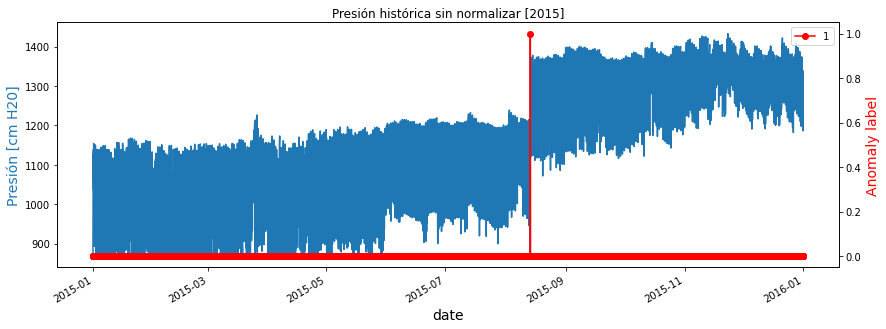

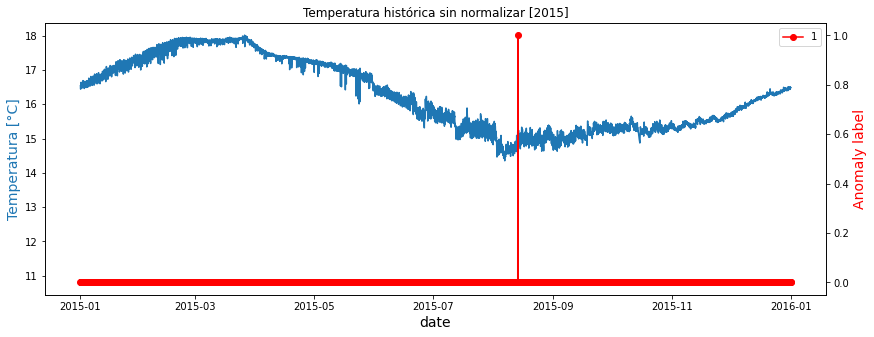

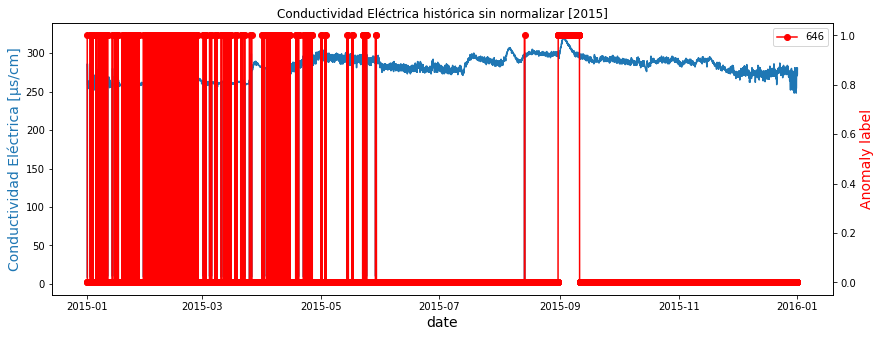

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(new_df['Pression [cm H2O]']['2015'])#,color='red')
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("Presión [cm H20]",fontsize=14,color='#1f77b4')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Presión histórica sin normalizar [2015]')
# ax.plot(new_df['Etiqueta P']['2015'].values*1000)
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(new_df['Etiqueta P']['2015'],color="red",marker="o",label=str(new_df['Etiqueta P']['2015'].value_counts()[1]))
ax2.set_ylabel("Anomaly label",color="red",fontsize=14)
ax2.legend()
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

# print(new_df['Etiqueta P']['2015'].value_counts())
axis1 = fig.add_subplot(311)
###############################
fig2, ax = plt.subplots(figsize=(14,5))
ax.plot(new_df['Temperatura [°C]']['2015'])#,color='red')
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label

ax.set_ylabel("Temperatura [°C]",fontsize=14,color='#1f77b4')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Temperatura histórica sin normalizar [2015]')
# ax.plot(new_df['Etiqueta P']['2015'].values*1000)
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(new_df['Etiqueta T']['2015'],color="red",marker="o",label=str(new_df['Etiqueta T']['2015'].value_counts()[1]))
ax2.set_ylabel("Anomaly label",color="red",fontsize=14)
ax2.legend()
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

# print(new_df['Etiqueta T']['2015'].value_counts())
axis2 = fig.add_subplot(312)
###############################
fig3, ax = plt.subplots(figsize=(14,5))
ax.plot(new_df['EC [µs/cm]']['2015'])#,color='red')
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label

ax.set_ylabel("Conductividad Eléctrica [µs/cm]",fontsize=14,color='#1f77b4')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Conductividad Eléctrica histórica sin normalizar [2015]')
# ax.plot(new_df['Etiqueta P']['2015'].values*1000)
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(new_df['Etiqueta EC']['2015'],color="red",marker="o",label=str(new_df['Etiqueta EC']['2015'].value_counts()[1]))
ax2.set_ylabel("Anomaly label",color="red",fontsize=14)
# "Count Anomaly in the period= " 
ax2.legend()
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')
axis3 = fig.add_subplot(313)
# # print(new_df['Etiqueta T']['2015'].value_counts())

# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# for fig in xrange(1, figure().number): ## will open an empty extra figure :(
#     pdf.savefig( fig )
# pdf.close()


fig.savefig('multipleplots.png')

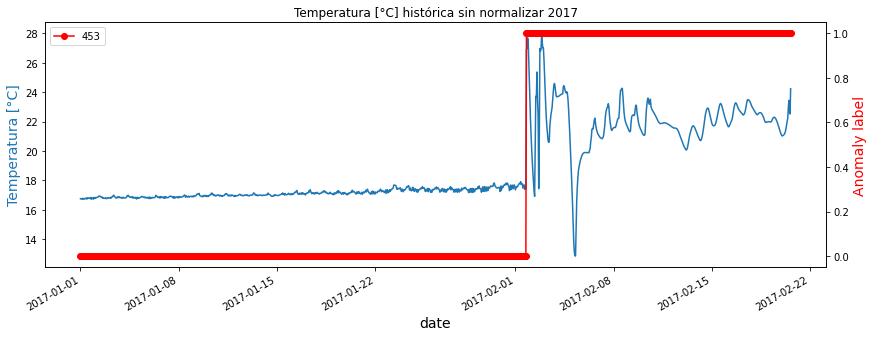

0    763
1    453
Name: Etiqueta T, dtype: int64


In [ ]:
year ='2017'
param = 'Temperatura [°C]' #'Pression [cm H2O]' # 'EC [µs/cm]' , 'Temperatura [°C]'
etiq = 'Etiqueta T' # 'Etiqueta EC' , 'Etiqueta T'

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(new_df[param][year])#,color='red')
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel(param,fontsize=14,color='#1f77b4')

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title( param + ' histórica sin normalizar '+year)

fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
try:
  count=str(new_df[etiq][year].value_counts()[1])
except:
  count="0"
ax2.plot(new_df[etiq][year],color="red",marker="o", label=count)
ax2.set_ylabel("Anomaly label",color="red",fontsize=14)
ax2.legend()
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

print(new_df[etiq][year].value_counts())

## Paso 1: Normalización con media 0 y STD 1.



<!-- from import wea -->

In [ ]:
df_new.head()

In [ ]:
df_norm = df_new
df_norm.head()
df_norm['Pressure'] = stats.zscore(df_new['Pressure'])

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df_norm.index, df_norm['Pressure'])
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Presión histórica normalizada')


In [ ]:
print(df_norm.shape)
df_norm.describe()


## Paso 2: Reducción de dimensionalidad (PAA)

Se agrupan los datos por día y se comprueba que todos los días tengan al menos 24 datos (horarios)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: ignored

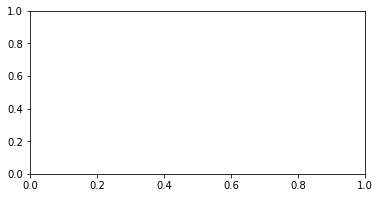

In [ ]:
# Se agrupan los datos por días
db_by_day = [group[1] for group in new_df.groupby(new_df.index.date)]

plt.plot(db_by_day)

## Paso 3: Trend Feature Extraction 


### Trend Distance


In [ ]:
df_new.index

NameError: ignored

In [ ]:
dia_inc=[]
n_data=[]
for i in range(len(db_by_day)):
  # print(i)
  n=db_by_day[i].shape[0]
  n_data+= [n]
  if n<24:
    
    dia_inc+= [i]

print('missing data on days', dia_inc)
try:
  print(len(db_by_day[0]), len(db_by_day[1451]))

except:
  pass
# Se recortan los  
db_by_day = db_by_day[1:-1]

In [ ]:
trend_distance=[]
m=[]
for day in (db_by_day):
  media=np.mean(day.Pressure.values)
  m += [media]

t_dist  =(day.Pressure[0]-media)-(day.Pressure[-1] - media)
  trend_distance += [t_dist]

In [ ]:
print('longitud de distancia= ',len(trend_distance), 'longitud de media= ',len(m))

# WPST: Weighted probabilistic suffix trees

In [ ]:
from suffix_trees import STree
st = STree.STree(ts_sax)

NameError: ignored

In [ ]:
print(st.find("abc")) # 0
print(st.find_all("ab")) # {0, 8}

Como se había mencionado anteriormente, en la presentación, se requiere que la data de entrenamiento sea 'normal' por lo que se eliminan los outliers de este conjunto.

In [ ]:
z_scores = scipy.stats.zscore(df_train)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X_train = df_train[filtered_entries]
X_train

# Pruebas HMM


In [ ]:
pip install hmmlearn

     |████████████████████████████████| 378kB 4.3MB/s 


In [ ]:
%matplotlib inline

width = 6
height = 3
import matplotlib
matplotlib.rcParams['figure.figsize'] = [width, height]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn

from hmmlearn.hmm import GaussianHMM

In [ ]:
print(pd.__version__)
print(np.__version__)
print(hmmlearn.__version__)

1.1.5
1.19.5
0.2.5


In [ ]:
vals = np.expand_dims(new_df['Pression [cm H2O]'].values, 1)
n_states = 2
model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
hidden_states = model.predict(vals)

In [ ]:
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

In [ ]:
def plot_states(ts_vals, states, time_vals,title):
    fig, ax1 = plt.subplots(figsize=(16,9))

    color = 'tab:red'
    ax1.set_title(title)
    ax1.set_xlabel('Year')

    ax1.set_ylabel('Temperature',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

[1013.22229584 1340.94043901 1206.19236527]
[60.68873977 35.15959197 37.86933809]


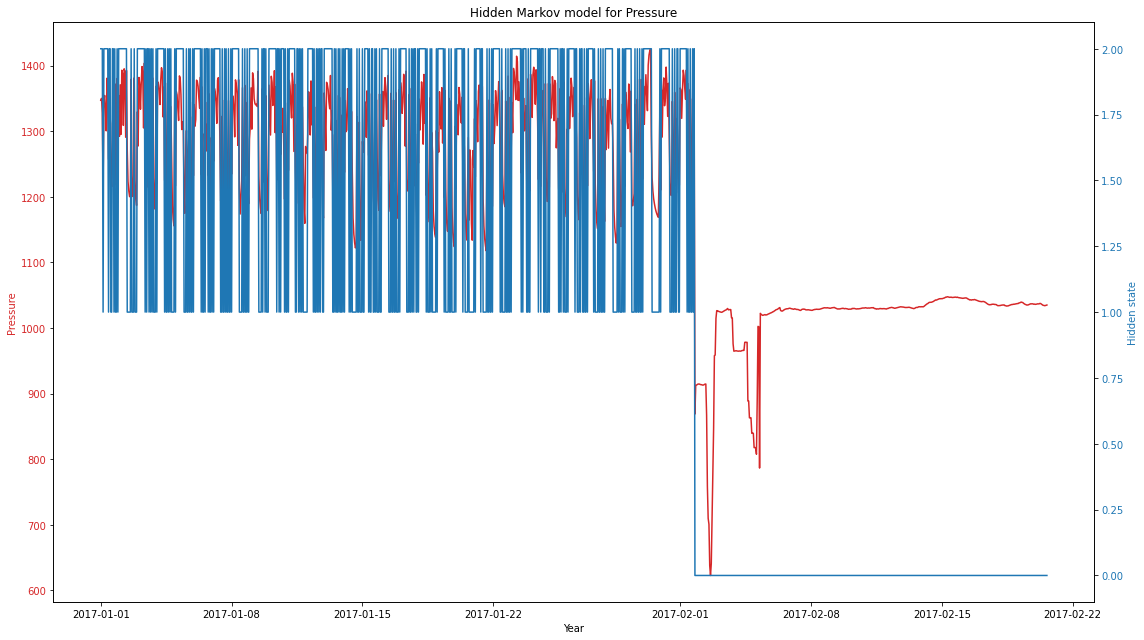

In [ ]:
pp=new_df['Pression [cm H2O]'].dropna()

vals = np.expand_dims(pp['2017'], 1)
hidden_states, mus, sigmas, transmat, model = fitHMM(vals, 3)
plot_states(pp['2017'], hidden_states, pp['2017'].index,'Hidden Markov model for Pressure')

In [ ]:
pp

0         981.5
1         871.1
2         870.7
3        1025.5
4         870.3
          ...  
34822    1034.4
34823    1034.0
34824    1034.2
34825    1034.6
34826    1035.0
Name: Pression [cm H2O], Length: 34827, dtype: float64

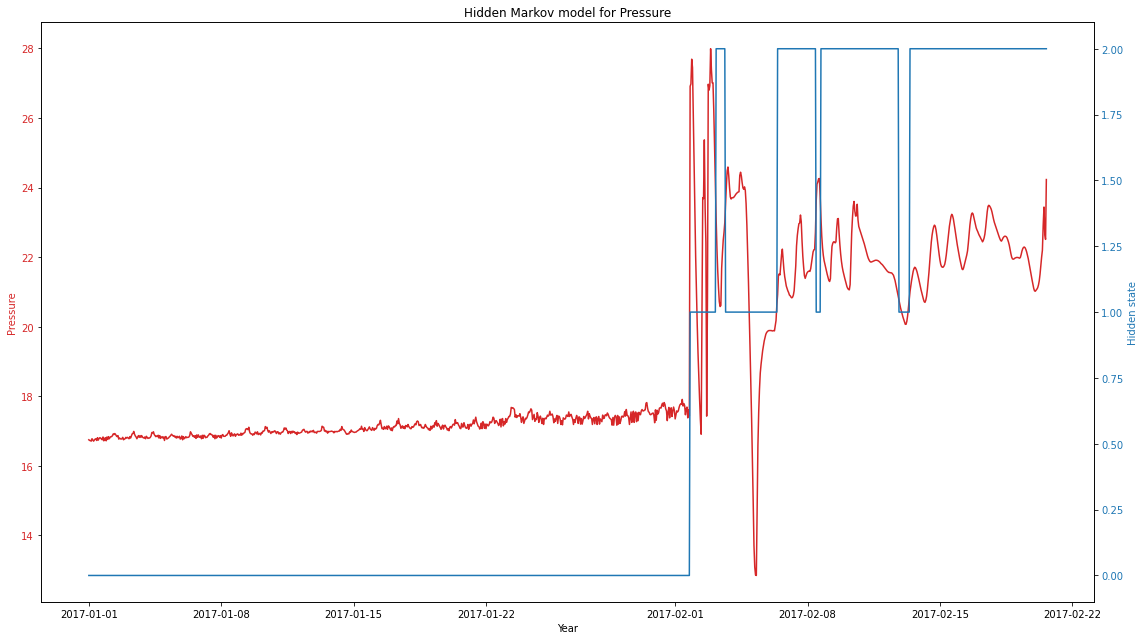

[17.1294882  22.06241768 21.70521089]
[0.25839727 0.7053138  3.302754  ]


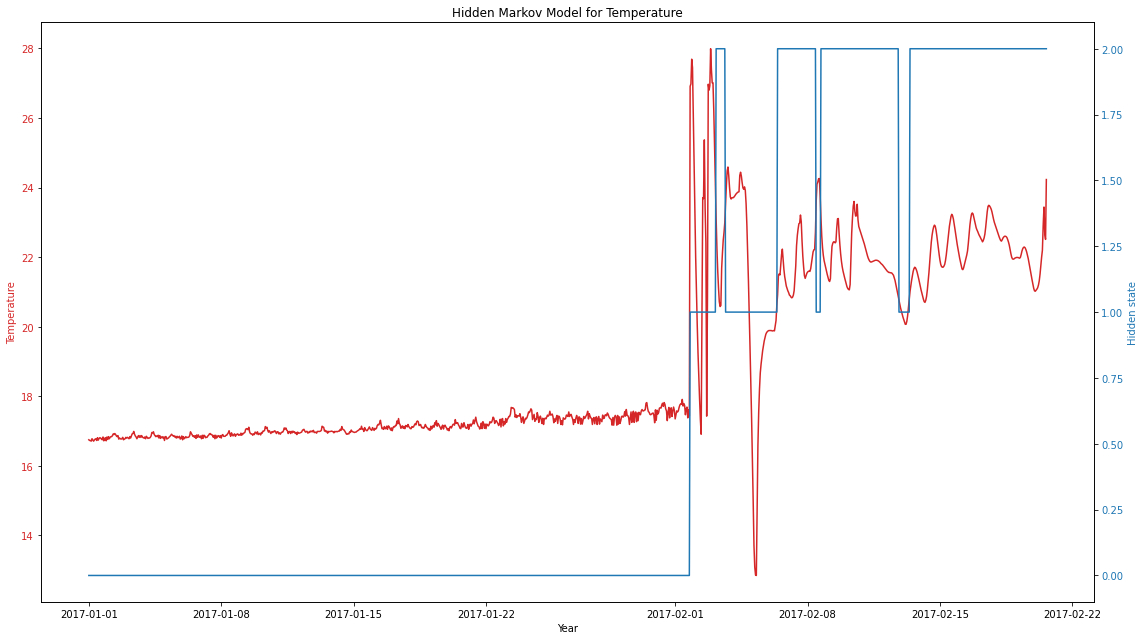

In [ ]:
pp=new_df['Temperatura [°C]'] .dropna()

vals = np.expand_dims(pp['2017'], 1)
hidden_states, mus, sigmas, transmat, model = fitHMM(vals, 3)
plot_states(pp['2017'], hidden_states, pp['2017'].index,'Hidden Markov Model for Temperature')

In [ ]:
np.bincount(hidden_states)

array([18064,  4000, 12763])

Plot Sax

In [ ]:
pip install tslearn

     |████████████████████████████████| 798kB 6.5MB/s 


In [ ]:
numpy.random.seed(0)
# Generate a random walk time series
n_ts, sz, d = 1, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
print(dataset[0,0:5])
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series

paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))


[Documentación 
](https://tslearn.readthedocs.io/en/stable/auto_examples/misc/plot_sax.html)

In [ ]:
pression = np.expand_dims(new_df['Pression [cm H2O]'].values,axis=(0, 1))
print(type(pression), pression.shape)
pression.shape = [1,34827,1]
print(type(pression), pression.shape)


<class 'numpy.ndarray'> (1, 1, 34827)
<class 'numpy.ndarray'> (1, 34827, 1)


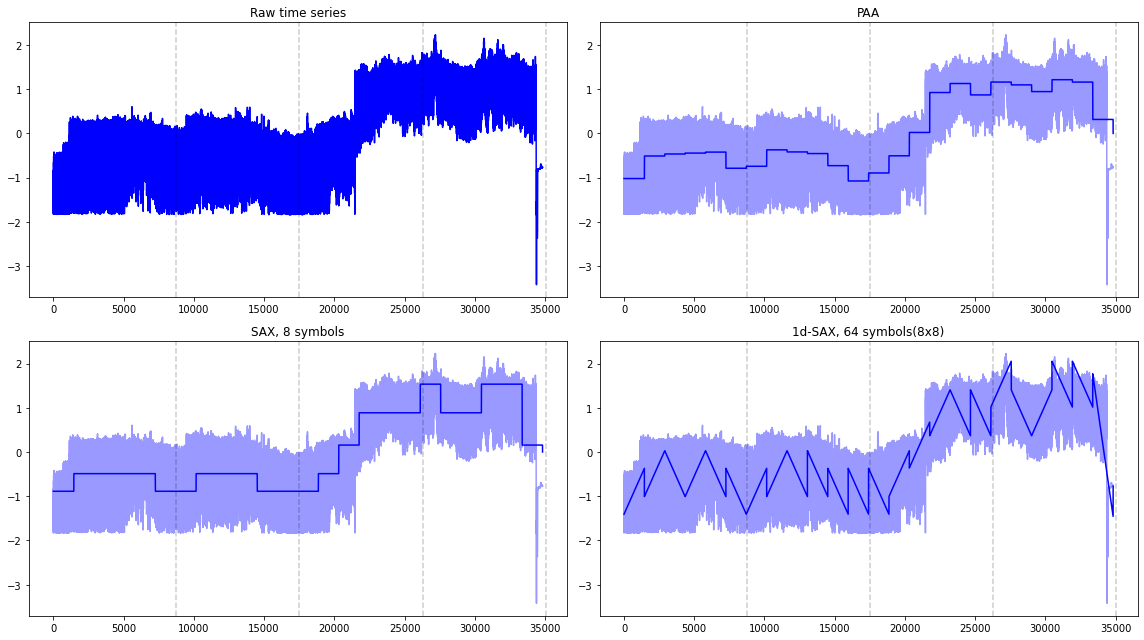

In [ ]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, \
    OneD_SymbolicAggregateApproximation

dataset = pression

scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(dataset)

# PAA transform (and inverse transform) of the data
n_paa_segments = 24
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)

sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)
transformed_data = one_d_sax.fit_transform(dataset)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(transformed_data)


plt.figure(figsize=(16,9))

years=[8760,17520,26280,35040]

plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(dataset[0].ravel(), "b-")
plt.title("Raw time series")
for year in years:
    plt.axvline(year, color='k', linestyle='--', alpha=0.2)

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")
for year in years:
    plt.axvline(year, color='k', linestyle='--', alpha=0.2)

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)
for year in years:
    plt.axvline(year, color='k', linestyle='--', alpha=0.2)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))
for year in years:
    plt.axvline(year, color='k', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
vals = np.expand_dims(paa_dataset_inv[0].ravel(), 1)
hidden_states, mus, sigmas, transmat, model = fitHMM(vals, 3)

[ 0.97994946 -0.39663506 -0.87460762]
[0.26104407 0.15370796 0.13410735]


<Figure size 1152x648 with 0 Axes>

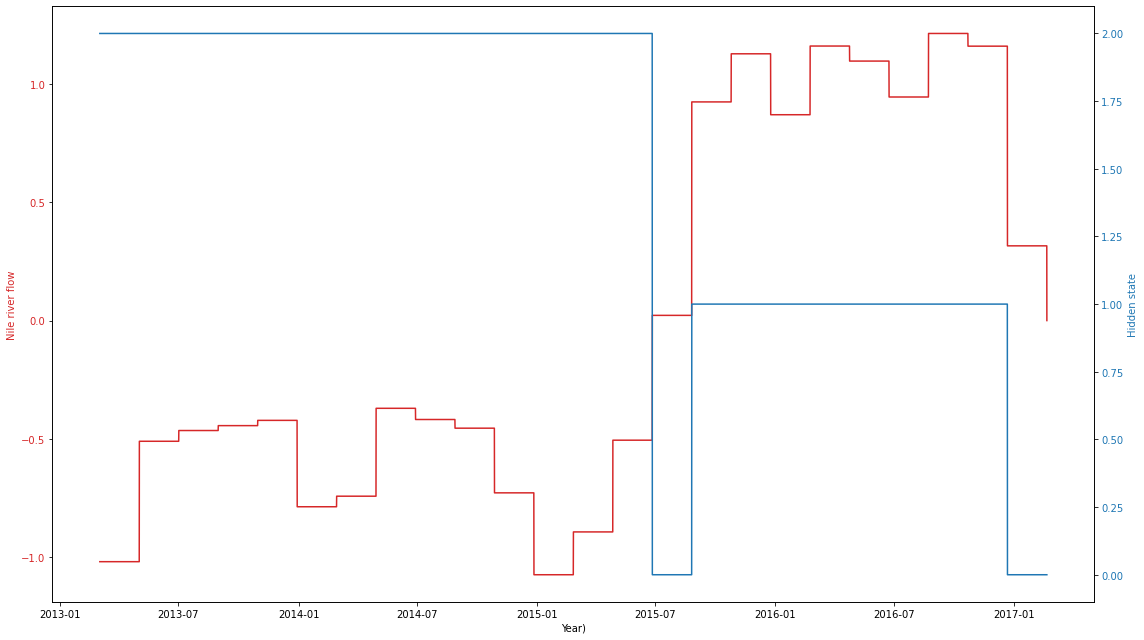

In [ ]:
plt.figure(figsize=(16,9))
plot_states(paa_dataset_inv[0].ravel(), hidden_states, new_df.index)

In [ ]:
start_date = datetime.datetime(1996,1,1)
end_date = datetime.datetime(2000,1,1)
  

In [ ]:
range(start_date.year,end_date.year)
for year in range(start_date.year,end_date.year):
  print(year)

1996
1997
1998
1999


# Old Database

In [ ]:
# en esta línea 
old_path = "/content/drive/MyDrive/[Fondef agua] Sistema Experto/Datasets/2021-01/database/horcon-data.xlsx"
df = pd.read_excel(old_path,parse_dates=[['Horcon', 'Unnamed: 1']])
df.head()


In [ ]:
# Pre procesamiento de los datos
df = df.drop(['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'], axis=1)
df.head()

KeyError: ignored

In [ ]:
# remove first two rows
df = df.drop([0,1], axis=0)
# rename variables
df = df.rename({'Horcon_Unnamed: 1': 'Timestamp', 'Unnamed: 2': 'Pressure', 'Unnamed: 3': 'Temperature', 'Unnamed: 4': 'CE'}, axis=1)
# reset row index
df = df.reset_index(drop=True)
df.head()

,Timestamp,Pressure,Temperature,CE
0,2013-03-02 00:00:00 13:00:00,981.5,17.81,0.257
1,2013-03-02 00:00:00 14:00:00,871.1,17.86,0.009
2,2013-03-02 00:00:00 15:00:00,870.7,17.8,0.009
3,2013-03-02 00:00:00 16:00:00,1025.5,17.71,0.256
4,2013-03-02 00:00:00 17:00:00,870.3,17.84,0.009


In [ ]:
for i in range(df.shape[0]):
  df['Timestamp'][i] = df['Timestamp'][i][0:11]+df['Timestamp'][i][20:] 

In [ ]:
df.head()

In [ ]:
df.Timestamp = pd.to_datetime(df['Timestamp'])
df.head()

In [ ]:
df.set_index('Timestamp',inplace=True)
df.head()

In [ ]:
df.head()

In [ ]:
# replace 'none' for NaN value
df.replace(to_replace=['none'], value=np.nan, inplace=True)
# remove rows containing NaN values
df.dropna(inplace=True)
# df
df.describe()

,Horcon_Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
count,13366,13366.0,13366.00,13366,13366.0,13366.00,13366.000,13366.0,13366.00
unique,13366,2787.0,660.00,114,655.0,1600.00,212.000,345.0,1494.00
top,2015-11-10 00:00:00 03:00:00,1379.3,15.24,0,910.7,10.98,0.136,872.8,21.84
freq,1,29.0,97.00,451,88.0,31.00,436.000,413.0,28.00


In [ ]:
df.index.values

# Old SAX


In [ ]:
pip install pyts

from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string
from saxpy.paa import paa


In [ ]:
db_by_day[364].shape


# df ya normalizada
# df_paa = paa(df_norm['Pressure'].values, 1460)

# disc=cuts_for_asize(5)
# print(df_paa)
# ts_sax=ts_to_string(df_paa, disc)
# print(ts_sax)
# print('Largo secuencia normalizada: ',df_norm.shape[0])
# print('Largo secuencia discretizada por Paa: ',len(df_paa))

# # Reducción a Data casi Diaria.
# df_norm.shape[0]/len(df_paa)
# n_samples, n_timestamps = 100, 24
# rng = np.random.RandomState(41)
# X = rng.randn(n_samples, n_timestamps)
# plt.figure(figsize=(14, 5))
# plt.title('Primer acercamiento SAX data diaria ')
# plt.plot(df_paa)#range(df_paa.shape[0]),
# plt.hlines(disc, 0, max(range(df_paa.shape[0])))
# plt.grid()

In [ ]:
plt.plot(df_paa[350:400])

In [ ]:
x=new_df['Pression [cm H2O]'].values
x=x[3:]
x.shape
x_sax=np.split(x,1451)


In [ ]:
x_arr = np.array(x_sax)
x_arr[350:400].shape

(50, 24)

In [ ]:
# x_sax

In [ ]:
# x_sax=x_sax[0:30]
len(x_sax)
np.mean(x_arr[30])

991.4625

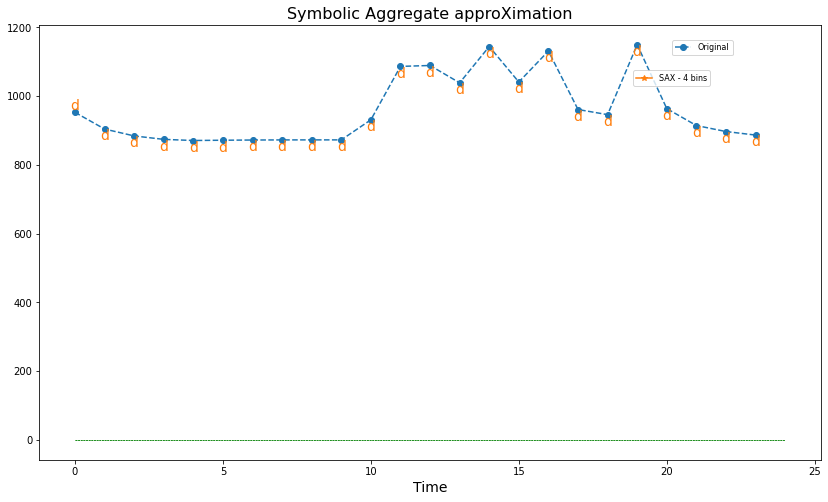

In [ ]:

import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyts.approximation import SymbolicAggregateApproximation

# Parameters
n_samples, n_timestamps = 24, 24

# Toy dataset

X = x_arr[350:400]

# SAX transformation
n_bins = 4
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
X_sax = sax.fit_transform(X)

# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(14, 8))
plt.plot(X[0], 'o--', label='Original')
for x, y, s, bottom in zip(range(n_timestamps), X[0], X_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, n_timestamps, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()

In [ ]:
from collections import Counterts
print(Counter(ts_sax))

ImportError: ignored

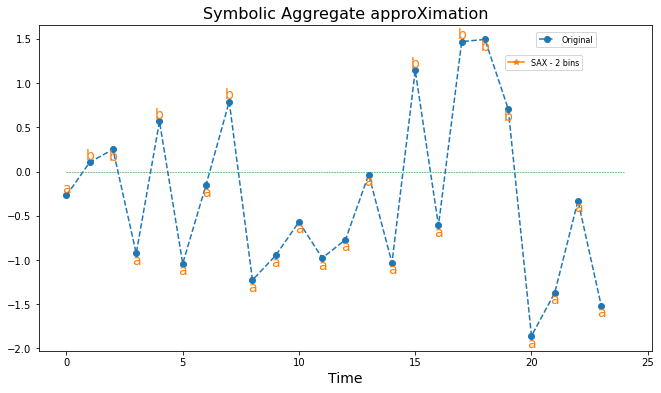

In [ ]:
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyts.approximation import SymbolicAggregateApproximation

# Parameters
n_samples, n_timestamps = 100, 24

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_timestamps)

# SAX transformation
n_bins = 2
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
X_sax = sax.fit_transform(X)

# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(11,6 ))
plt.plot(X[0], 'o--', label='Original')
for x, y, s, bottom in zip(range(n_timestamps), X[0], X_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, n_timestamps, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()


# Detecting Anomalies with Deviation Method

AttributeError: ignored

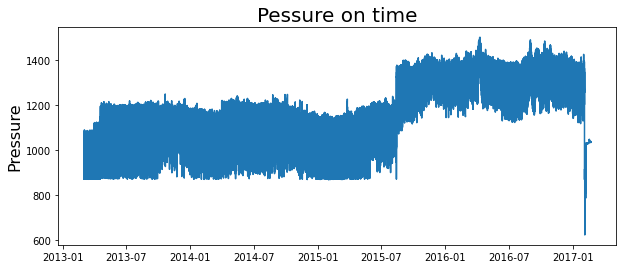

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(new_df['Pression [cm H2O]'])
plt.title('Pessure on time', fontsize=20)
plt.ylabel('Pressure', fontsize=16)
start_date=2013
end_date=2017
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
new_df.head()

,Pression [cm H2O],Etiqueta P,Temperatura [°C],Etiqueta T,EC [µs/cm],Etiqueta EC
Date_Time,,,,,,
2013-03-02 13:00:00,981.5,1,17.81,0,257,0
2013-03-02 14:00:00,871.1,1,17.86,0,9,1
2013-03-02 15:00:00,870.7,1,17.80,0,9,1
2013-03-02 16:00:00,1025.5,1,17.71,0,256,0
2013-03-02 17:00:00,870.3,1,17.84,0,9,1


In [ ]:
rolling_deviations = new_df['Pression [cm H2O]']
rolling_deviations

Date_Time
2013-03-02 13:00:00     981.5
2013-03-02 14:00:00     871.1
2013-03-02 15:00:00     870.7
2013-03-02 16:00:00    1025.5
2013-03-02 17:00:00     870.3
                        ...  
2017-02-20 11:00:00    1034.4
2017-02-20 12:00:00    1034.0
2017-02-20 13:00:00    1034.2
2017-02-20 14:00:00    1034.6
2017-02-20 15:00:00    1035.0
Name: Pression [cm H2O], Length: 34827, dtype: float64

In [ ]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = new_df['Pression [cm H2O]'].loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

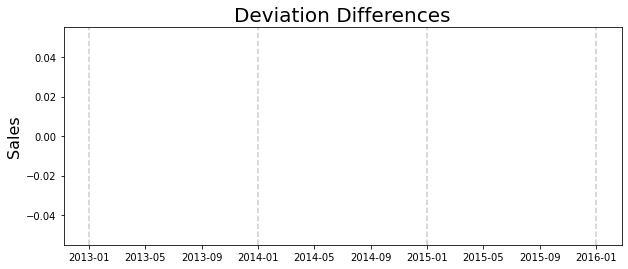

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(2013,2017):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)